# Weekly Assignment 4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import csv
from random import sample
from scipy.stats import norm

Create the class "airbnb" which will gather all the features as attributes and some methods to retrieve specific features, necessary for the process of training and prediction.

In [2]:
class airbnb( object ):
    
    def __init__(self, latitude, longitude, neighbourhood_group, price, availability, room_type, minimum_nights):
        self.latitude=latitude
        self.longitude=longitude
        self.neighbourhood=neighbourhood_group
        self.price=price
        self.availability=availability
        self.room_type=room_type
        self.minimum_nights=minimum_nights
    
    def getFeaturesDict(self): return {"latitude": self.latitude, "longitud": self.longitude}
    def getFeaturesTuple(self): return (self.latitude,self.longitude)
    def getFeatureskmeans(self): return (self.price, self.availability, self.minimum_nights, self.room_type, self.neighbourhood)
    
    def getNeighbour(self): return self.neighbourhood

Loading data from the file, converting rows into airbnb objects and gathering them into a list (myairbnbs).

In [3]:
myairbnbs = []
with open("listings.csv") as data:
    data = csv.reader(data)
    next(data)
    for line in data:
        apartment = airbnb(float(line[6]),float(line[7]),line[4],float(line[9]),int(line[-1]),line[8],int(line[10]))
        myairbnbs.append(apartment)

# Classification with Naive Bayes

First we sample 2000 apartments randomly from the whole dataset. We divide these into a test set and a training set.

In [4]:
sampling = sample(myairbnbs, k = 2000)
test_set = sampling[:1000]
training_set = sampling[1000:]

The classifier class is the same as the one we saw in lesson 7, I just changed some variable names to make it more readable and changed the properties (or features) taken into account. In this case, the classifier takes latitude and longitud as features and neighbour group as the tag.

In [5]:
class NaiveBayesOfairnbns( object ):
 
    def _distributionProbFunction(self,neighbourhood, Property):
        # Return the result of evaluating a Normal distribution of:
        #   mean equal to the mean of the property for this neighbourhood group
        #   std  equal to the std  of the property for this neighbourhood group
        return lambda x: norm.pdf( x, self.cmean[neighbourhood][Property], self.cstdv[neighbourhood][Property] )
        
    def __init__(self, training_set):
        self.training_set = training_set
 
        self.neighbourhoods = {}
        for apartment in self.training_set:
            if apartment.getNeighbour() in self.neighbourhoods.keys():
                self.neighbourhoods[apartment.getNeighbour()] += 1
            else: self.neighbourhoods[apartment.getNeighbour()] = 1
 
        self.probl = {}
        self.N = len(self.training_set[0].getFeaturesDict())
        self.properties = list(self.training_set[0].getFeaturesDict().keys())
        self.cmean = {}
        self.cstdv = {}
        self.prob = {}
        
        for neighbourhood in self.neighbourhoods.keys():
            # The amount of fruits of each type that I have in my "training" dataset
            self.probl[neighbourhood] = self.neighbourhoods[neighbourhood]/len(self.training_set)
            
            # I will store the mean, std, and normal probabiblity function,
            # of each property for each type of fruit
            self.cmean[neighbourhood] = {} #[0 for i in range(self.N)]
            self.cstdv[neighbourhood] = {} #[0 for i in range(self.N)]
            self.prob[neighbourhood] = {} #[0 for i in range(self.N)]
            
            # Then, for each property
            for i, prop in enumerate(self.properties):
                # Make a numpy array taking the list of the read properties
                xi = np.array([float(e.getFeaturesDict()[prop]) for e in self.training_set if e.getNeighbour() == neighbourhood])
                
                # Fullfill the mean with the mean, the std with the std and the prob with the probability function
                self.cmean[neighbourhood][prop] = xi.mean()
                self.cstdv[neighbourhood][prop] = xi.std()
                self.prob[neighbourhood][prop] = self._distributionProbFunction(neighbourhood,prop)

    def predict(self, X):
        p = {}
        
        # In the moment of predicting I have the probabilities of each feature of belonging to each class.
        for neighbourhood in self.neighbourhoods.keys():
            vectorToMultiply = [self._distributionProbFunction(neighbourhood,prop)(X[i]) 
                                    for i, prop in enumerate(self.properties)
                                    if self._distributionProbFunction(neighbourhood,prop)(X[i]) != 0.0 ] 
            cp = np.prod( vectorToMultiply )
            
            p[neighbourhood] = self.probl[neighbourhood]*cp
            
        results = [(p[neighbourhood],neighbourhood) for neighbourhood in self.neighbourhoods.keys()]
        results.sort()
        return results[-1][1], results[-1][0]/sum([r[0] for r in results])

    def plotDistributions(self):
        for i, prop in enumerate(self.properties):
            nprops=len(range(self.N))
            rows = int(nprops/2)+int(nprops%2)
            plt.subplot(rows,2,i+1)
            for neighbourhood in list(self.neighbourhoods.keys()):
                mean = self.cmean[neighbourhood][prop]
                var = self.cstdv[neighbourhood][prop]
                x= np.linspace(mean-4*var,mean+4*var,200)
                xmin,xmax=plt.xlim()
                plt.xlim(min(xmin,mean-3*var),max(xmax,mean+3*var))
                plt.title(self.properties[i])
                
                self.prob[neighbourhood][prop] = self._distributionProbFunction(neighbourhood,prop)

                plt.plot(x,self.prob[neighbourhood][prop](x), label = neighbourhood)
                leg = plt.legend(loc="upper left")
                leg.get_frame().set_alpha(0.7)
        plt.show()
        
    def __str__(self):
        s = 'Gaussian Naive Bayes Model:\n'
        for l in self.neighbourhoods.keys():
            s+= ' P(%s) = %.3f\n'%(l, self.probl[l])
            for i,prop in enumerate(self.properties):
                s+= '  E(%s|%s) = %.3f\n'%(self.properties[i], l, self.cmean[l][prop])
                s+= '  VAR(%s|%s) = %.3f\n'%(self.properties[i], l, self.cstdv[l][prop]**2)
                s+= '\n'
        return s.strip()

Finally, we train the model with the training samples.

In [6]:
myNBC = NaiveBayesOfairnbns(training_set)

This last chunk of code is for the assessment of the accuracy of the classifier, that is, the percetange of correct predictions over the total number of predictions.

In [7]:
correct = 0
for elem in test_set:
    pred = myNBC.predict(elem.getFeaturesTuple())
    if pred[0] == elem.getNeighbour():
        correct += 1
acc = correct/len(test_set)
print("Accuracy = %s"%(acc))

Accuracy = 0.865


# Clusterization with K-means

In [4]:
def vector_euclidian_distance(feat_one, feat_two):
    squared_distance = 0
    #Assuming correct input to the function where the lengths of two features are the same
    for i in range(len(feat_one)):
            squared_distance += (feat_one[i] - feat_two[i])**2
    ed = math.sqrt(squared_distance)
    return ed

class K_Means:

    def __init__(self, k =3, tolerance = 0.0001, max_iterations = 500):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations
    

    def fit(self, data):
        #initialize the centroids, the first 'k' elements in the dataset will be our initial centroids
        self.centroids = [None for _ in range(self.k)]
        for i in range(self.k):
            self.centroids[i] = data[i]
            
        for i in range(self.max_iterations):
            self.classes = {c:[] for c in range(self.k)}
            for i in range(self.k):
                self.classes[i] = []
                #find the distance between the point and cluster; choose the nearest centroid
                for features in data:
                    distances = [vector_euclidian_distance(features, self.centroids[centroid]) for centroid in range(len(self.centroids))]
                    classification = distances.index(min(distances))
                    self.classes[classification].append(features) #add the point to the list of the nearest centroid


            #average the cluster datapoints to re-calculate the centroids
            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis = 0)

We extract the relevant features from the dataset and modify room_type to be a discrete numerical variable

In [5]:
data = [airbnb.getFeatureskmeans() for airbnb in myairbnbs]

room_type_list = [apartment[3] for apartment in data]
room_type_set = list(set(room_type_list))
numerical_room_types = [room_type_set.index(x) for x in room_type_list]

neigh_list = [apartment[4] for apartment in data]
neigh_set = list(set(neigh_list))
numerical_neigh = [neigh_set.index(x) for x in neigh_list]

price = [apartment[0] for apartment in data]
avaliability = [apartment[1] for apartment in data]
minimum_nights = [apartment[2] for apartment in data]


data = list(zip(price, numerical_room_types))


Fit the clustering to the selected data to 3 groups.

In [13]:
km = K_Means(3)
km.fit(data)

for centroid in km.centroids:
    print ("Centroid:", centroid)
    
print(list(room_type_set))

Centroid: [852.73921971   0.86652977]
Centroid: [82.55088038  1.51369759]
Centroid: [5.81522500e+03 7.58333333e-01]
['Hotel room', 'Entire home/apt', 'Private room', 'Shared room']


Plot the results

In [6]:
colors = 10*["r", "g", "c", "b", "k", "m", "y", "lime", "pink", "gray"]
color_gradient = ["lavender","powderblue","lightsteelblue","cadetblue","darkcyan"]

In [7]:
color_n = [colors[i] for i in numerical_neigh] #set a color for each neighbour group

In [8]:
color_a = [] #set a color for each range of availability
for aptment in avaliability:
    if aptment <= 30:
        color_a.append(color_gradient[0])
    elif aptment > 30 and aptment <= 60:
        color_a.append(color_gradient[1])
    elif aptment > 60 and aptment <= 120:
        color_a.append(color_gradient[2])
    elif aptment > 120 and aptment <= 240:
        color_a.append(color_gradient[3])
    elif aptment > 240:
        color_a.append(color_gradient[4])

In [9]:
color_m = []
for aptment in minimum_nights:
    if aptment <= 1:
        color_m.append(color_gradient[0])
    elif aptment > 1 and aptment <= 5:
        color_m.append(color_gradient[1])
    elif aptment > 5 and aptment <= 15:
        color_m.append(color_gradient[2])
    elif aptment > 15 and aptment <= 30:
        color_m.append(color_gradient[3])
    else:
        color_m.append(color_gradient[4])

Colored according to cluster group. We see that in all room types there are cheap (green), middle priced (red) and expensive (cyan) records. We only see a difference in that the hotel room type looks like it is slightly more expensive.

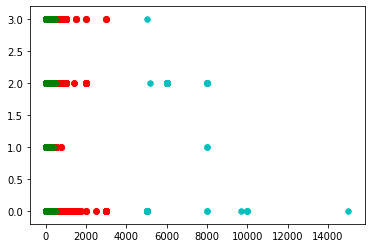

In [10]:
for classification in km.classes:
    color = colors[classification]
    for features in km.classes[classification]:
        plt.scatter(features[0], features[1], color = color,s = 30)

Colored according to minimum nights, availability and neighbourhood group

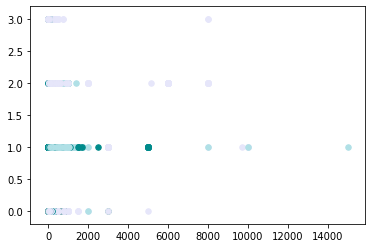

In [10]:
for i, datapoint in enumerate(data):
    plt.scatter(datapoint[0], datapoint[1], color = color_m[i], s = 30)

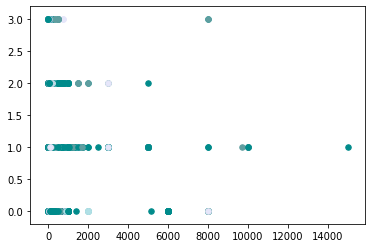

In [11]:
for i, datapoint in enumerate(data):
    plt.scatter(datapoint[0], datapoint[1], color = color_a[i], s = 30)

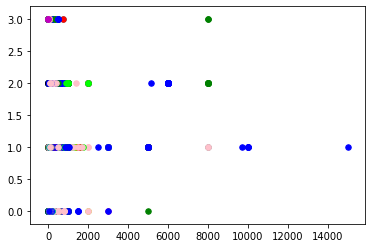

In [11]:
for i, datapoint in enumerate(data):
    plt.scatter(datapoint[0], datapoint[1], color = color_n[i], s = 30)

We do not see any special distribution of the datapoints in the groups when observing the points colored by minimum nights, availability or neighbourhood group.